#Multivariate Time Series LSTM

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime




In [ ]:
# dataset link: https://finance.yahoo.com/quote/GE/history?p=GE
from google.colab import files
uploaded = files.upload ()


In [ ]:
df = pd.read_csv('GE.csv')

In [ ]:
train_dates = pd.to_datetime(df["Date"]) #separating dates for using it as an  axis in a future plot
cols = list(df)[1:6] #variables for training #extracting Date,open, high,low, close, ask close.
df_for_training = df[cols].astype(float) #converting the extracted values into a new dataframe

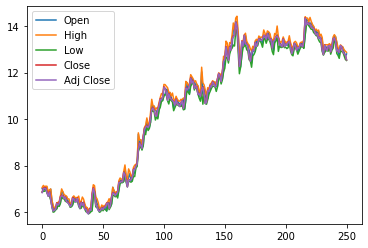

In [ ]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [ ]:
#define autoencoder model

model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))  #trainX.shape[1] is 14/# of days, trainX.shape[2] is 5 ie  num of features.return_sequence is true so the sequence returned by the lstm should be the same as that processed by the next lstm
model.add(LSTM(32, activation='relu', return_sequences=False)) #sequence is false as the next layer is drop out and dense for whic hsequence is not imp
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=10, batch_size =16, validation_split=0.1, verbose=1)

Epoch 1/10
14/14 [==============================] - 27s 116ms/step - loss: 0.7803 - val_loss: 0.0566
Epoch 2/10
14/14 [==============================] - 0s 16ms/step - loss: 0.1189 - val_loss: 0.0216
Epoch 3/10
14/14 [==============================] - 0s 15ms/step - loss: 0.0960 - val_loss: 0.0355
Epoch 4/10
14/14 [==============================] - 0s 16ms/step - loss: 0.0631 - val_loss: 0.0139
Epoch 5/10
14/14 [==============================] - 0s 16ms/step - loss: 0.0669 - val_loss: 0.0213
Epoch 6/10
14/14 [==============================] - 0s 16ms/step - loss: 0.0582 - val_loss: 0.0228
Epoch 7/10
14/14 [==============================] - 0s 15ms/step - loss: 0.0618 - val_loss: 0.0210
Epoch 8/10
14/14 [==============================] - 0s 16ms/step - loss: 0.0712 - val_loss: 0.0084
Epoch 9/10
14/14 [==============================] - 0s 16ms/step - loss: 0.0466 - val_loss: 0.0265
Epoch 10/10
14/14 [==============================] - 0s 16ms/step - loss: 0.0405 - val_loss: 0.0119


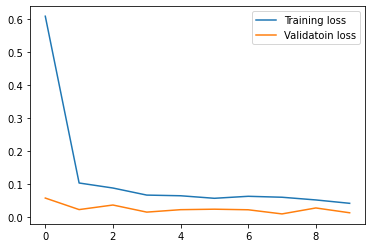

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validatoin loss')
plt.legend()

In [ ]:
#Forecasting
#Using the last day of the training date to predict the future
n_future=90 #redefining n_future to extend prediction dates beyond original n_future dates
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods = n_future, freq='1d').tolist() #predict 90 days into the future with a frequency of 1 day. train_dates[-1] is the last dau at which the training stopped, subsequent values indicate predictions made based on model
forecast = model.predict(trainX[-n_future:])

In [ ]:
#using inverse tranformation to rescale back to orignical range
#Since we used 5 variables for transform during normalization, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform

forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis = -1) #repeating the forecast 5 times which is equal to training.shape[1](contains 5 features) so that the inverse transform doesnt show an error. For it initially was fit on 5 features
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0] # this means we are only looking at the first column and not the other 4 columns after as they all contain the same data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

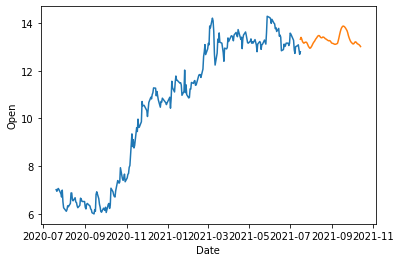

In [ ]:
#Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future}) #placing forecast dates and y_pred_future in a dataframe
df_forecast["Date"] = pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']] #grabbing the original data and open datafram
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1'] # were only looking at values after 5/1 to allow a greater spread of data to be visualized

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])